# Imports

In [1]:
# Logging and warnings
import logging

# File R/W
import os

# Additional Inbuilt Utilities
import itertools
import functools

# Regex
import re

# Array
import numpy as np

# Table
import pandas as pd

# Advanced Computations
import scipy as sc

# Statistics
import statsmodels.api as sm
import statsmodels.stats as st

# Neurophysiological Data Analysis
import mne
import mne_nirs # esp. for fNIRS

# Neuroimaging Statistical Tools
import nilearn
import nilearn.plotting

# Plotting
import matplotlib.pyplot as plt

# Vistual Display
from pyvirtualdisplay import Display

In [2]:
# Autoreload Custom Modules
%load_ext autoreload
%autoreload 1

# Custom Class
%aimport nirs
NIRS = nirs.NIRS

# Custom Settings
%aimport constants

# Custom Functions
%aimport utils

# Modified MBLL
%aimport mbll

## Config

In [3]:
# Set logging level for custom modules
logging.getLogger().setLevel(logging.INFO)

In [4]:
# Set logging level for MNE
mne.set_log_level('WARNING')

In [5]:
# Set plotting backend for MNE
mne.viz.set_browser_backend('matplotlib') # qt, matplotlib
mne.viz.set_3d_backend('notebook') # pyvistaqt, notebook

# READ DATA

---

---

# MAIN

##### `Pre-Processing`

In [6]:
# Instantiate NIRS() and read data
nirs = NIRS(project='Working-Memory') # Working-Memory # Multi-object Tracking
nirs.read(30, 1, 1, augment=False, transform=False, correction_factor=1.0, backlight=False);

In [7]:
nirs.raw.crop(tmax=3000)

<RawArray | 44 x 40002 (3000.0 s), ~13.5 MB, data loaded>

In [8]:
# nirs.save_short_channels()
# nirs.raw.drop_channels(utils.find_short_channels(nirs.raw.ch_names)[0])
# Filter frequencies outside hemodynamic response range
mne.filter.FilterMixin.filter(nirs.raw,
    l_freq=0.01,
    h_freq=0.1,
    l_trans_bandwidth=0.006,
    h_trans_bandwidth=0.006
);
# mne_nirs.signal_enhancement.enhance_negative_correlation(nirs.raw);

In [9]:
nirs.get_epochs(tmin=-2,
                tmax=12,
                baseline=(-0.075, 0),
                # reject_criteria={'hbo': 0.03, 'hbr': 0.03},
                plot_drop_log=False);

# Drop epochs where response was not correct
# nirs.epochs.drop(nirs.mat['id_correct'] != 1);

# nirs.block_average();

##### `GLM Analysis`

In [10]:
# raw_intensity = savepoints['CW']
raw_haemo = nirs.raw.copy().pick(nirs.good_ch_names)

In [11]:
design_matrix = mne_nirs.experimental_design.make_first_level_design_matrix(raw_haemo,
                                                                            hrf_model= 'spm', # 'spm + derivative + dispersion',
                                                                            drift_model=None, # 'cosine', 'polynomial'
                                                                            # drift_order=3,
                                                                            # high_pass=1/2/(nirs.DUR['trial']),
                                                                            stim_dur=nirs.DUR['motion'])

# design_matrix['mean_ss_hbo'] = np.mean(nirs.raw_ss.copy().pick('hbo').get_data(), axis=0)
# design_matrix['mean_ss_hbr'] = np.mean(nirs.raw_ss.copy().pick('hbr').get_data(), axis=0)

In [12]:
glm_est = mne_nirs.statistics.run_glm(raw_haemo, design_matrix)
glm_results = glm_est.to_dataframe()

In [13]:
glm_results['Significant'] = st.multitest.multipletests(glm_results['p_value'])[0]

In [14]:
glm_results_significant = glm_results[glm_results['Significant']]
significant_channels = list(glm_results_significant[glm_results_significant['Condition'] == 'HIGH']['ch_name'].unique())

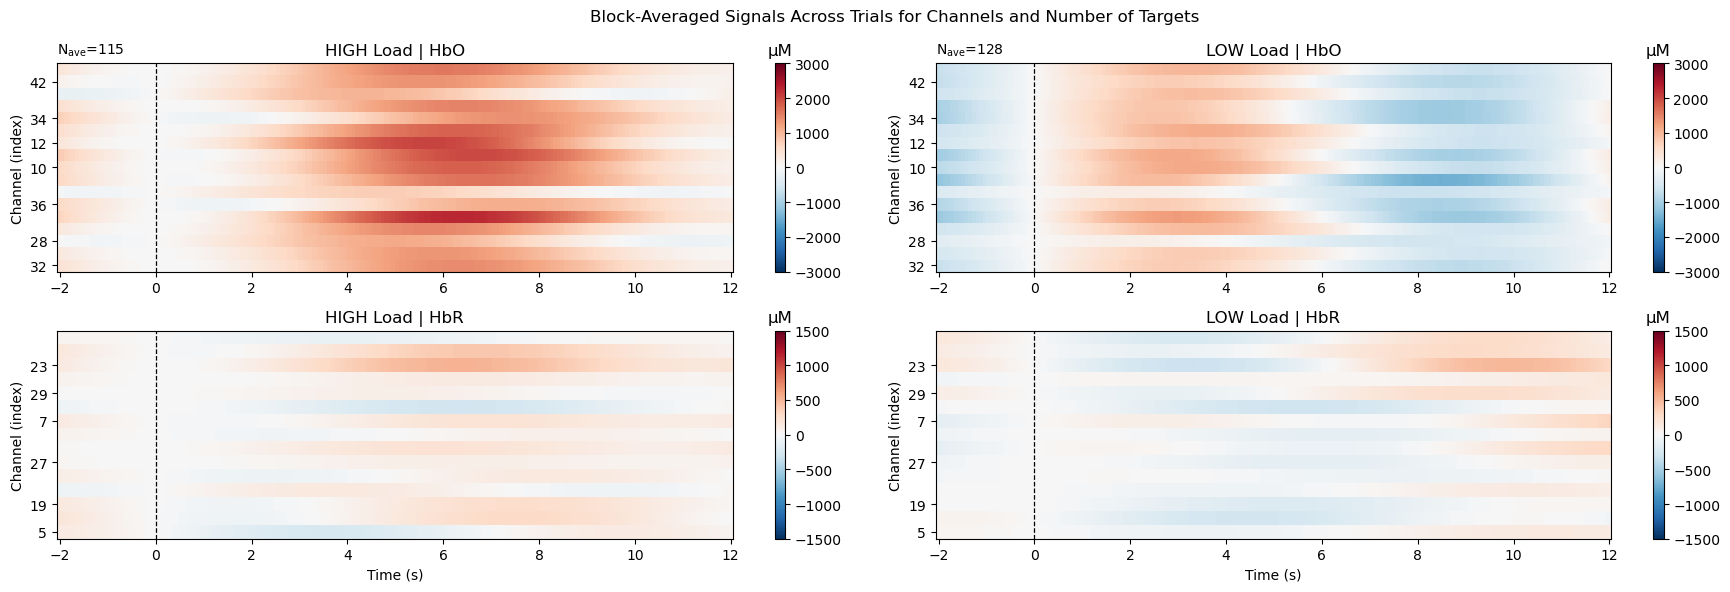

In [15]:
nirs.plot_average_heatmap(picks=list(set(significant_channels) - {'S7_D7 hbr'}), clim={'hbo': [-3000, 3000], 'hbr': [-1500, 1500]}).tight_layout()

In [16]:
significant_pairs = utils.find_ch_pairs(nirs.raw.ch_names, significant_channels)

In [17]:
evoked_dict = {
    'HIGH/hbo': nirs.epochs['HIGH'].average(picks=utils.find_channels_type('hbo', significant_channels + significant_pairs)[0]),
    # 'HIGH/hbr': nirs.epochs['HIGH'].average(picks=utils.find_channels_type('hbr', significant_channels + significant_pairs)[0]),
    'LOW/hbo': nirs.epochs['LOW'].average(picks=utils.find_channels_type('hbo', significant_channels + significant_pairs)[0]),
    # 'LOW/hbr': nirs.epochs['LOW'].average(picks=utils.find_channels_type('hbr', significant_channels + significant_pairs)[0])
}

In [18]:
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x.split(' ')[0])

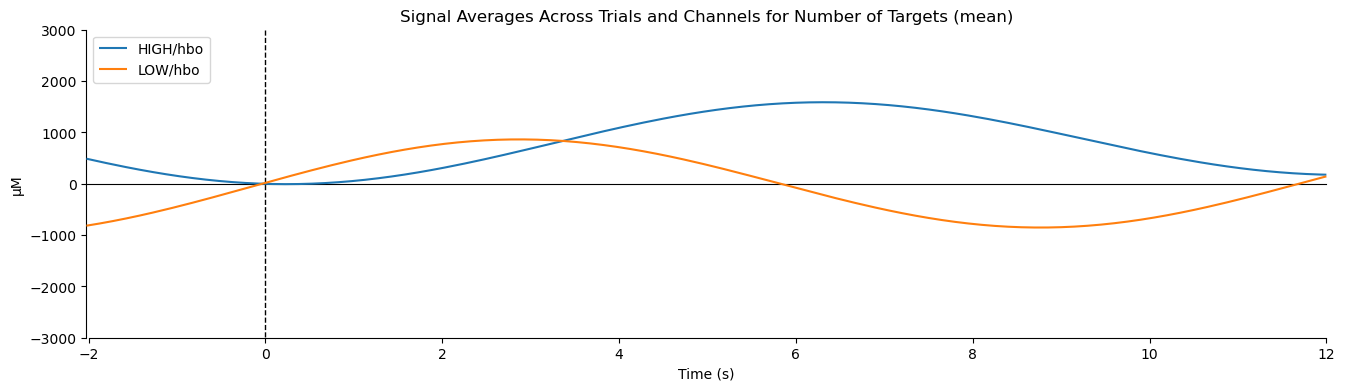

In [19]:
mne.viz.plot_compare_evokeds(evoked_dict, combine='mean', ci=0.95, axes=plt.figure(figsize=(16, 4)).add_subplot(111),
                             # colors={'0': 'k', '2': 'r', '3':'g', '4':'b', '5':'y'},
                             linestyles={'hbo': '-'},
                                         # 'hbr': ':'},
                             ylim={'hbo': [-3000, 3000]},
                             title='Signal Averages Across Trials and Channels for Number of Targets');

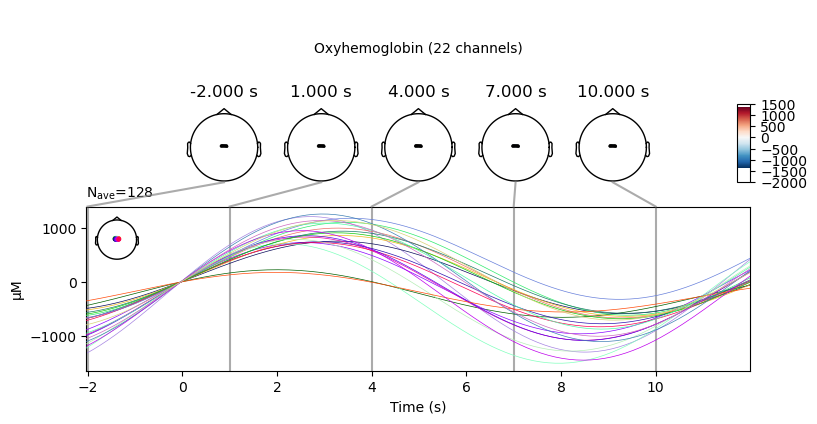

In [20]:
nirs.epochs['LOW'].average(picks=utils.find_channels_type('hbo', significant_channels + significant_pairs)[0]).plot_joint(times=np.arange(nirs.T_EPOCH_START, nirs.T_EPOCH_END, 3), topomap_args={'extrapolate': 'local'});

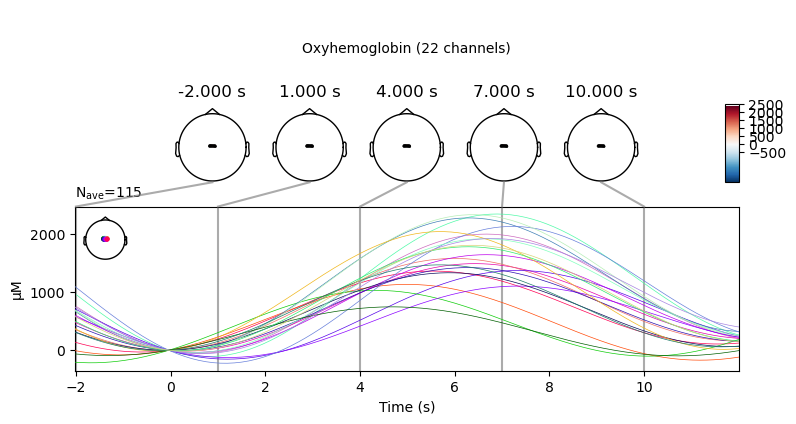

In [21]:
nirs.epochs['HIGH'].average(picks=utils.find_channels_type('hbo', significant_channels + significant_pairs)[0]).plot_joint(times=np.arange(nirs.T_EPOCH_START, nirs.T_EPOCH_END, 3), topomap_args={'extrapolate': 'local'});

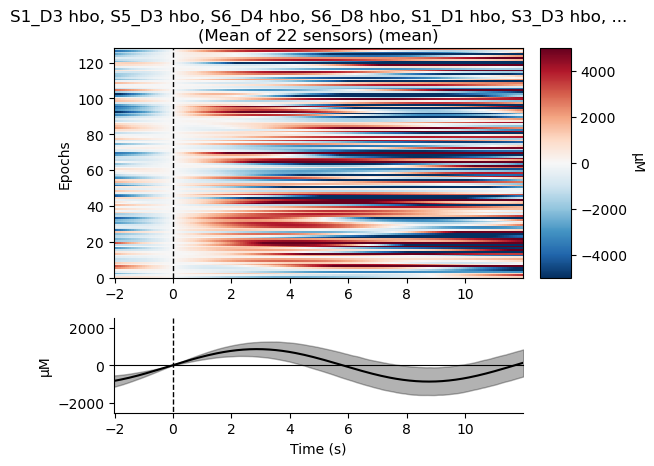

[<Figure size 640x480 with 3 Axes>]

In [22]:
nirs.epochs['LOW'].plot_image(picks=utils.find_channels_type('hbo', significant_channels + significant_pairs)[0], combine='mean', vmin=-5000, vmax=5000, ts_args=dict(ylim=dict(hbo=[-2500, 2500], hbr=[-2500, 2500])))

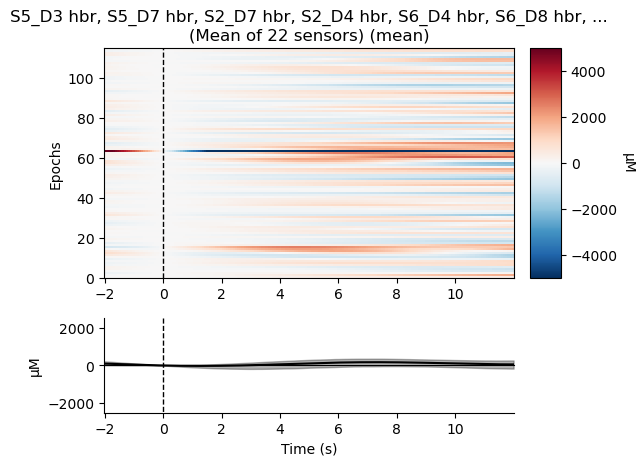

[<Figure size 640x480 with 3 Axes>]

In [23]:
nirs.epochs['HIGH'].plot_image(picks=utils.find_channels_type('hbr', significant_channels + significant_pairs)[0], combine='mean', vmin=-5000, vmax=5000, ts_args=dict(ylim=dict(hbo=[-2500, 2500], hbr=[-2500, 2500])))

##### `GLM Analysis (combined)`

##### `Plotting for GLM Analysis`

##### `Clustering`

> Relevant features  
>> For intervals of 1s in the epochs.  
>> - Area under the curve  
>> - Average slope  
>> - Maximum amplitude